In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from scipy.stats import zscore

## 1. Load the Dataset

In [55]:
# Load the dataset
file_path = "C:/Users/Eleanor Huang/Desktop/MLDS/Practicum/Dataset01.csv"  
df = pd.read_csv(file_path)

In [56]:
df.dtypes

MaskID          object
TypeID          object
Date            object
Step00Var1     float64
Step00Var2     float64
Step00Var3     float64
Step00Var4     float64
Step00Var5     float64
Step00Var6     float64
Step00Var7     float64
Step00Var8     float64
Step00Var9      object
Step00Var10     object
Step00Var11     object
Step00Var12     object
Step00Var13     object
Step00Var14     object
Step00Var15     object
Step01Var1     float64
Step01Var2     float64
Step01Var3     float64
Step01Var4     float64
Step01Var5      object
Step01Var6      object
Step01Var7      object
Step01Var8      object
Step01Var9      object
Step01Var10     object
Step01Var11     object
Step01Var12     object
Step01Var13    float64
Step01Var14    float64
Step01Var15    float64
Step01Var16    float64
Step02Var1     float64
Step02Var2     float64
Step02Var3     float64
Step02Var4     float64
Step02Var5     float64
Step02Var6     float64
Step03Var1     float64
Step03Var2      object
Step03Var3      object
Step03Var4 

## Data Preprocessing

### Deal with categorical Data: dummy transformation

In [57]:
# Define columns to process (all object columns except MaskID and TypeID)
excluded_cols = ['MaskID', 'TypeID']  # Columns you don't want to encode
columns_to_process = [col for col in df.select_dtypes(include=['object']).columns if col not in excluded_cols]

numerical_like_cols = []
categorical_cols = []

# Dictionary to fix any known misspellings in categorical columns
category_mappings = {
    'Step04Var4': {
        'Greater than a DIme': 'Greater than a Dime',  # Correct typo
        'Less than a Dime': 'Less than a Dime',
        'Both (if multiple clumps)': 'Both (if multiple clumps)'
    }
}

# Apply mappings to fix categorical column values
for col, mapping in category_mappings.items():
    if col in df.columns:
        df[col] = df[col].replace(mapping)

# Process each column
for col in columns_to_process:
    unique_vals = df[col].dropna().unique()
    if len(unique_vals) > 20:  # Large number of unique values, likely numerical-like
        try:
            # Convert to numeric, replacing "Not Reported" or similar with NaN
            df[col] = pd.to_numeric(df[col].replace(['Not Reported'], np.nan), errors='coerce')
            numerical_like_cols.append(col)
        except ValueError:
            # If conversion fails, treat as categorical
            categorical_cols.append(col)
    else:
        categorical_cols.append(col)  # Treat as categorical if unique values are small

# Verify the classification of columns
print(f"Numerical-like columns: {numerical_like_cols}")
print(f"Categorical columns: {categorical_cols}")

# Handle one-hot encoding for categorical columns
if categorical_cols:
    print(f"One-hot encoding the following categorical columns: {categorical_cols}")
    df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Final summary
print("Numerical-like columns converted to numeric:", numerical_like_cols)
print("Categorical columns one-hot encoded:", categorical_cols)
print("Resulting DataFrame shape:", df.shape)
print("Resulting DataFrame columns:", df.columns)

Numerical-like columns: ['Date', 'Step00Var9', 'Step00Var10', 'Step00Var11', 'Step00Var12', 'Step00Var13', 'Step00Var14', 'Step00Var15', 'Step01Var5', 'Step01Var6', 'Step01Var7', 'Step01Var8', 'Step01Var9', 'Step01Var10', 'Step01Var12']
Categorical columns: ['Step01Var11', 'Step03Var2', 'Step03Var3', 'Step03Var4', 'Step03Var5', 'Step03Var9', 'Step03Var10', 'Step03Var11', 'Step03Var12', 'Step04Var2', 'Step04Var3', 'Step04Var4', 'Step04Var6', 'Step04Var7', 'Step04Var8', 'Step04Var9', 'Step04Var10']
One-hot encoding the following categorical columns: ['Step01Var11', 'Step03Var2', 'Step03Var3', 'Step03Var4', 'Step03Var5', 'Step03Var9', 'Step03Var10', 'Step03Var11', 'Step03Var12', 'Step04Var2', 'Step04Var3', 'Step04Var4', 'Step04Var6', 'Step04Var7', 'Step04Var8', 'Step04Var9', 'Step04Var10']
Numerical-like columns converted to numeric: ['Date', 'Step00Var9', 'Step00Var10', 'Step00Var11', 'Step00Var12', 'Step00Var13', 'Step00Var14', 'Step00Var15', 'Step01Var5', 'Step01Var6', 'Step01Var7', 'S

### Deal with numerical values: standardization 

In [58]:
var_cols = df.select_dtypes(include=[np.float64]).drop(columns=['Date']) # select only the process variables
from sklearn.preprocessing import StandardScaler

# Normalize the data using z-score standardization
scaler = StandardScaler()
normalized_vars = pd.DataFrame(
    scaler.fit_transform(var_cols), 
    columns=var_cols.columns
)

### Deal with null values: MICE imputation method

In [59]:
normalized_vars.isna().sum()

Step00Var1        4
Step00Var2        6
Step00Var3        6
Step00Var4        1
Step00Var5     4479
Step00Var6        5
Step00Var7        5
Step00Var8        6
Step00Var9       57
Step00Var10      57
Step00Var11      57
Step00Var12      57
Step00Var13      57
Step00Var14      57
Step00Var15      57
Step01Var1       18
Step01Var2       19
Step01Var3       19
Step01Var4       19
Step01Var5       58
Step01Var6       58
Step01Var7       55
Step01Var8       58
Step01Var9       58
Step01Var10      58
Step01Var12      58
Step01Var13       7
Step01Var14       7
Step01Var15       7
Step01Var16      18
Step02Var1       23
Step02Var2       25
Step02Var3       25
Step02Var4       26
Step02Var5       24
Step02Var6       29
Step03Var1       30
Step03Var6       30
Step03Var7       30
Step03Var8       31
Step04Var1       37
Step04Var5       40
Step04Var12      44
TargetVar        57
dtype: int64

In [43]:
pip install fancyimpute

Note: you may need to restart the kernel to use updated packages.Collecting fancyimpute
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Obtaining dependency information for cvxpy from https://files.pythonhosted.org/packages/22/f3/d9ad70707abf6f69e3b5bcac728920e383ccc9525f3a989e2d564a797ae4/cvxpy-1.6.0-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for cvxopt from https://files.pythonhosted.org/packages/a3/52/2237d72cf007e6c36367ab8a776388a9f13511e4cfa8a71b79101ad6e0fa/cvxopt-1.3.2-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for nose from https://files.pythonhosted.org/packages/15/d8/dd071918c040f50fa1cf80da16423af51ff8ce4a0f2399b7bf8de45ac3d9/nose-1.3.7-py3-none-any.whl.metadata
  Obtaining dependency information for osqp>=0.6.2 from https://files.pythonhosted.org/packages/f8/7b/ec4

In [60]:
from fancyimpute import IterativeImputer
mice_imputer = IterativeImputer(max_iter=10, random_state=42)
imputed_data = mice_imputer.fit_transform(normalized_vars)
# Convert the imputed NumPy array back to a DataFrame
imputed_vars = pd.DataFrame(imputed_data, columns=normalized_vars.columns)
# Show the first few rows of the imputed dataset
print(imputed_vars.head())

   Step00Var1  Step00Var2  Step00Var3  Step00Var4    Step00Var5  Step00Var6  \
0    0.725641   -1.205423    1.094996    1.166754  3.008490e-07   -0.058842   
1    0.092729    0.585571   -0.019708    0.228339 -3.625603e-08   -0.058842   
2    0.725641   -0.092836    0.123203    0.295369  2.725509e-07   -0.058842   
3    3.257289    1.164478    0.894921   -2.251758 -1.954847e+00   -2.055557   
4    1.991465    2.566519    1.523728   -0.441957 -2.794546e-07   -0.058842   

   Step00Var7  Step00Var8  Step00Var9  Step00Var10  ...  Step02Var5  \
0   -1.940292   -1.121645    0.740446    -0.636171  ...    0.157454   
1   -0.872137    0.582073    0.003804     0.184088  ...    0.216707   
2   -0.872137   -0.035373   -1.186157     1.473067  ...    0.311512   
3    0.196018    0.923897   -0.619509     0.887168  ...    0.275960   
4    0.196018    2.465485   -1.242821     1.590247  ...   -0.162512   

   Step02Var6  Step03Var1  Step03Var6  Step03Var7  Step03Var8  Step04Var1  \
0   -0.125484    1.94

d:\Program Files\Anaconda\Lib\site-packages\sklearn\impute\_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


## Initial Correlation Analysis   
No feature has significant correlation with the target variable, but some features have multicollinearity with each other

### The original correlation (with normalized data without imputation)

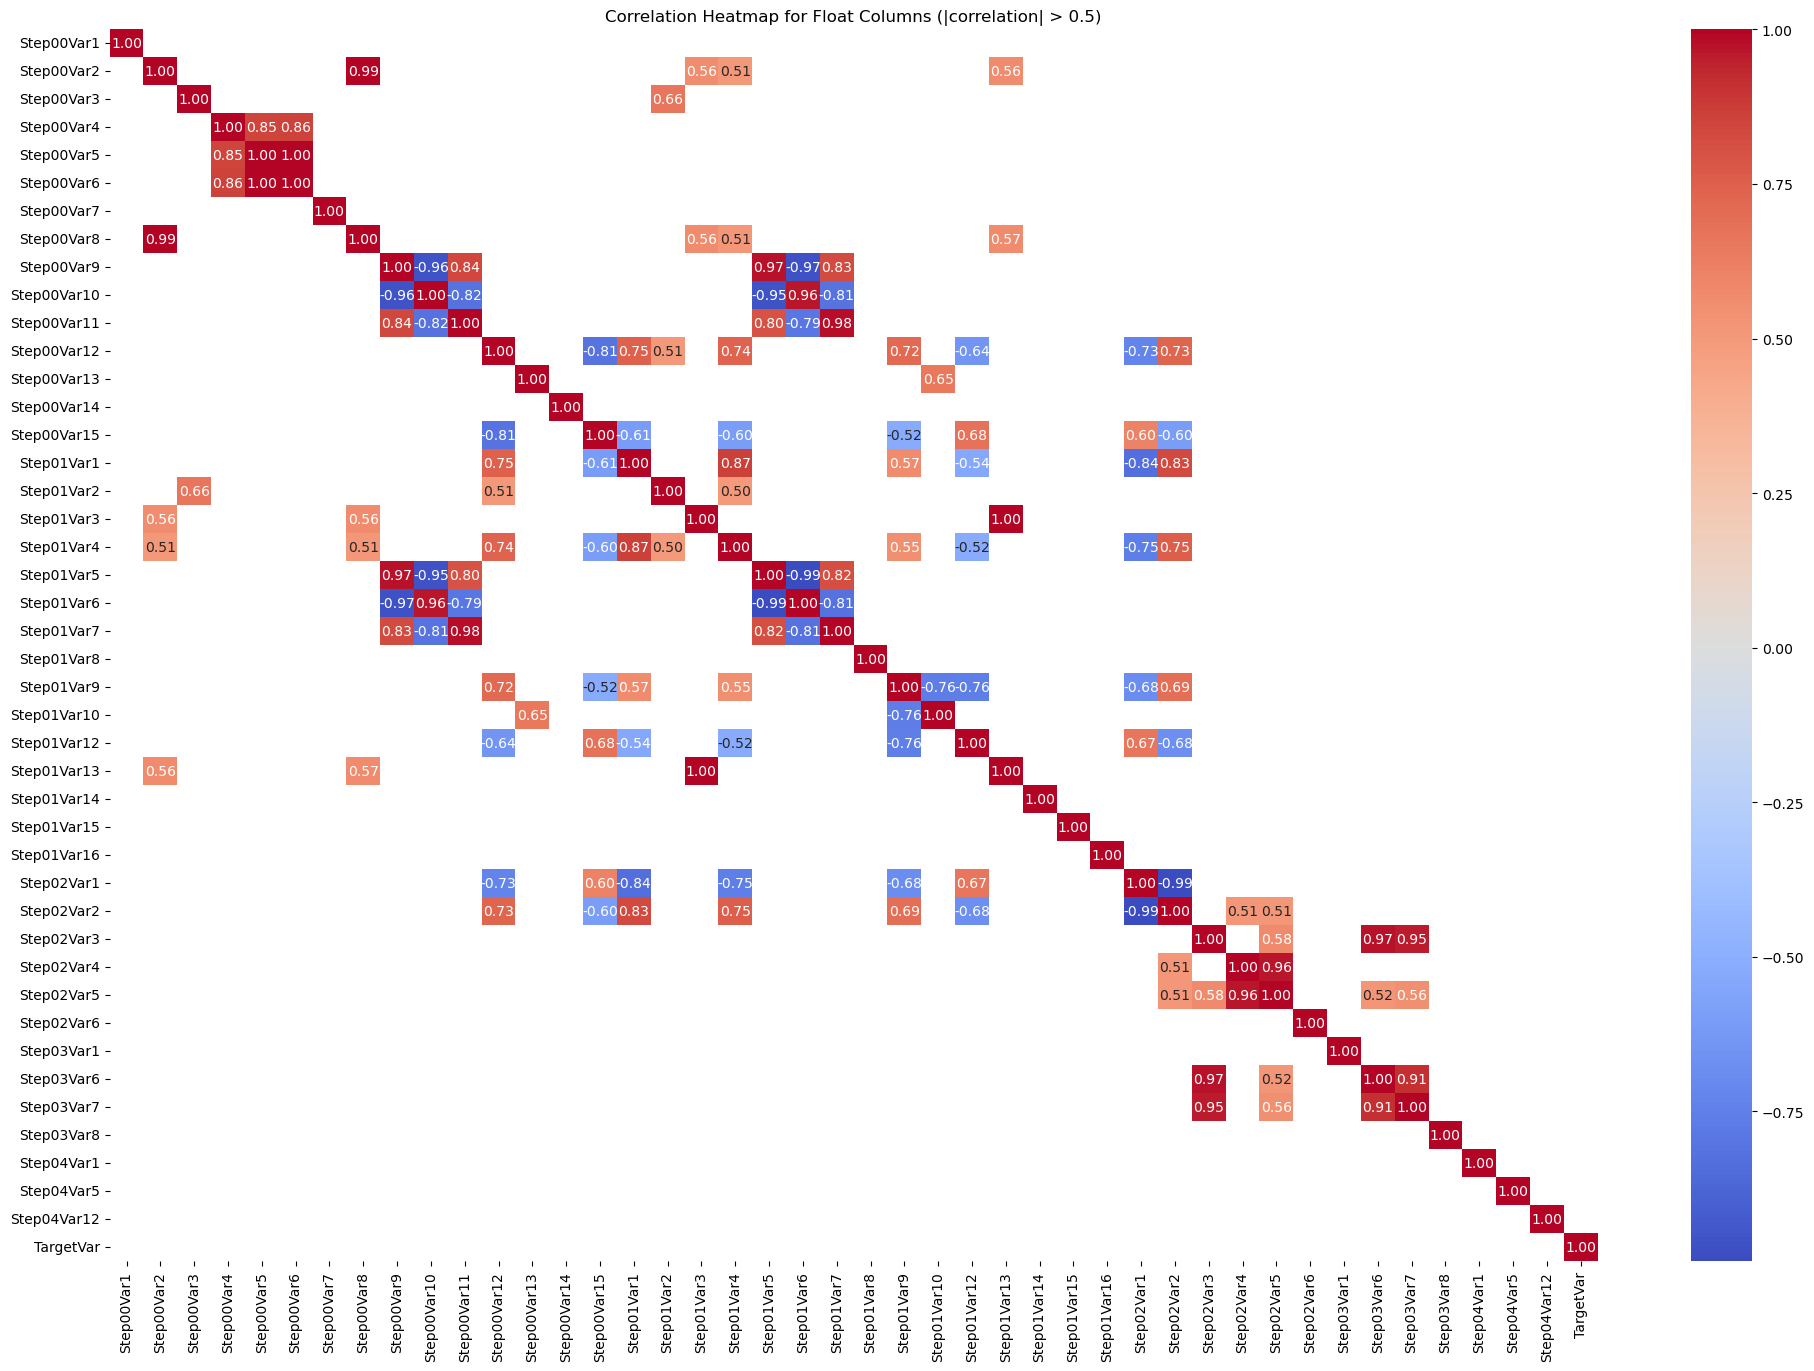

In [61]:
# Compute the correlation matrix for floating-point columns
correlation_matrix_floats = df[normalized_vars.columns].corr()

# Filter the correlation matrix to show only correlations above a certain threshold
threshold = 0.5
correlation_matrix_filtered_floats = correlation_matrix_floats.copy()
correlation_matrix_filtered_floats[(correlation_matrix_floats.abs() < threshold)] = np.nan

# Plot the heatmap with the filtered correlation matrix for float columns
plt.figure(figsize=(24, 16))
sns.heatmap(correlation_matrix_filtered_floats, annot=True, fmt=".2f", cmap="coolwarm", mask=correlation_matrix_filtered_floats.isnull())
plt.title(f"Correlation Heatmap for Float Columns (|correlation| > {threshold})")
plt.show()

In [62]:
# Extract pairs of highly correlated variables
high_corr_pairs = correlation_matrix_floats.unstack().reset_index()
high_corr_pairs.columns = ['Variable1', 'Variable2', 'Correlation']

# Filter out self-correlations and correlations below the threshold
high_corr_pairs = high_corr_pairs[(high_corr_pairs['Variable1'] != high_corr_pairs['Variable2']) & 
                                  (abs(high_corr_pairs['Correlation']) > 0.90)]

# Sort by absolute correlation value
high_corr_pairs = high_corr_pairs.sort_values(by='Variable1', ascending=True)
high_corr_pairs

,Variable1,Variable2,Correlation
404,Step00Var10,Step00Var9,-0.958809
415,Step00Var10,Step01Var5,-0.954608
416,Step00Var10,Step01Var6,0.964352
461,Step00Var11,Step01Var7,0.978925
51,Step00Var2,Step00Var8,0.994577
181,Step00Var5,Step00Var6,1.000000
224,Step00Var6,Step00Var5,1.000000
309,Step00Var8,Step00Var2,0.994577
361,Step00Var9,Step00Var10,-0.958809
371,Step00Var9,Step01Var5,0.969221


### The Imputed Correlation (with normalized and imputed data)

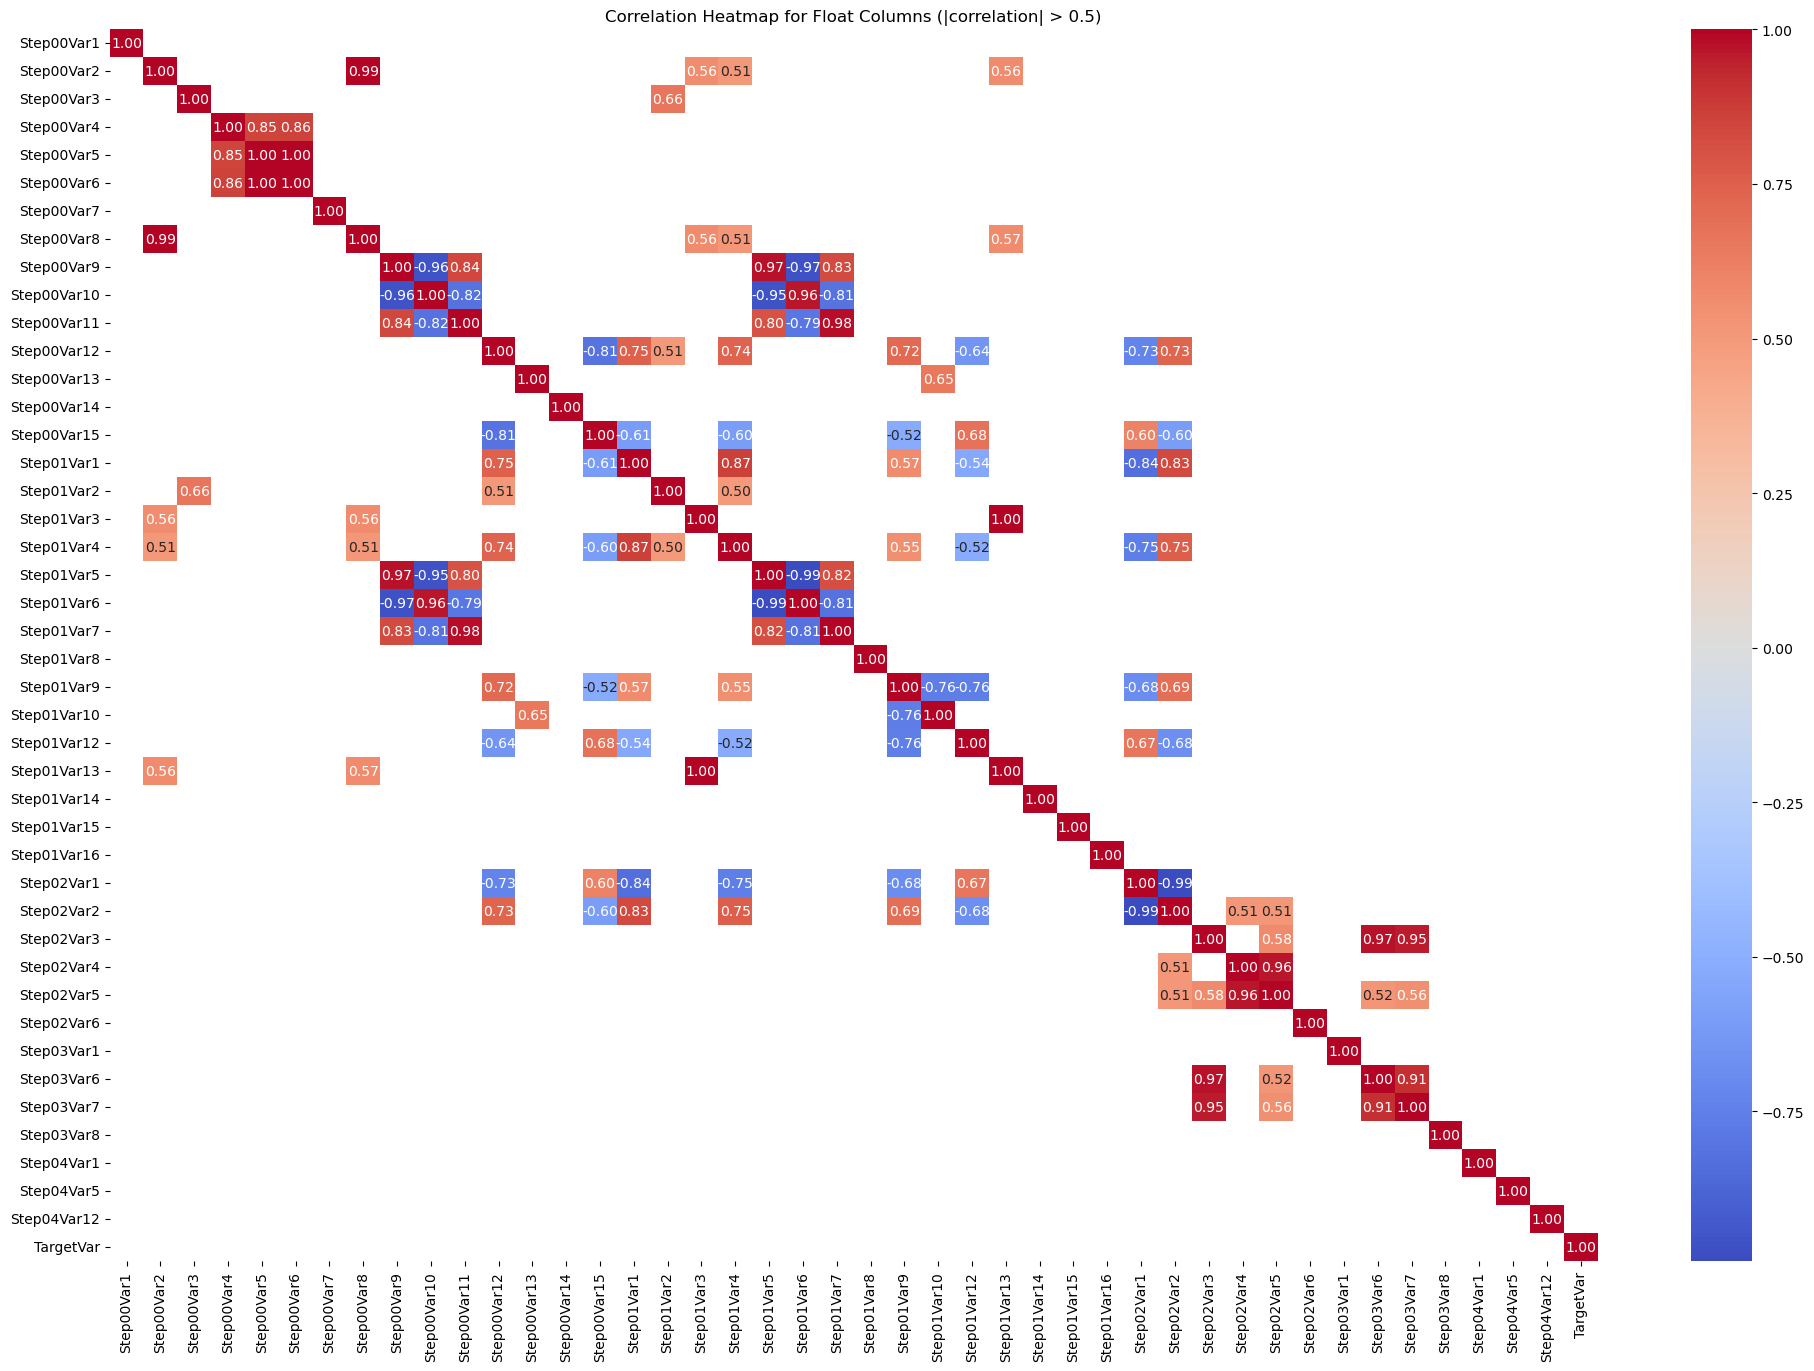

In [63]:
# Compute the correlation matrix for floating-point columns
correlation_matrix_floats = df[imputed_vars.columns].corr()

# Filter the correlation matrix to show only correlations above a certain threshold
threshold = 0.5
correlation_matrix_filtered_floats = correlation_matrix_floats.copy()
correlation_matrix_filtered_floats[(correlation_matrix_floats.abs() < threshold)] = np.nan

# Plot the heatmap with the filtered correlation matrix for float columns
plt.figure(figsize=(24, 16))
sns.heatmap(correlation_matrix_filtered_floats, annot=True, fmt=".2f", cmap="coolwarm", mask=correlation_matrix_filtered_floats.isnull())
plt.title(f"Correlation Heatmap for Float Columns (|correlation| > {threshold})")
plt.show()

In [64]:
# Extract pairs of highly correlated variables
high_corr_pairs = correlation_matrix_floats.unstack().reset_index()
high_corr_pairs.columns = ['Variable1', 'Variable2', 'Correlation']

# Filter out self-correlations and correlations below the threshold
high_corr_pairs = high_corr_pairs[(high_corr_pairs['Variable1'] != high_corr_pairs['Variable2']) & 
                                  (abs(high_corr_pairs['Correlation']) > 0.90)]

# Sort by absolute correlation value
high_corr_pairs = high_corr_pairs.sort_values(by='Variable1', ascending=True)
high_corr_pairs

,Variable1,Variable2,Correlation
404,Step00Var10,Step00Var9,-0.958809
415,Step00Var10,Step01Var5,-0.954608
416,Step00Var10,Step01Var6,0.964352
461,Step00Var11,Step01Var7,0.978925
51,Step00Var2,Step00Var8,0.994577
181,Step00Var5,Step00Var6,1.000000
224,Step00Var6,Step00Var5,1.000000
309,Step00Var8,Step00Var2,0.994577
361,Step00Var9,Step00Var10,-0.958809
371,Step00Var9,Step01Var5,0.969221


## Visualization of variables (comparison)

### The orginal boxplots and violin plots

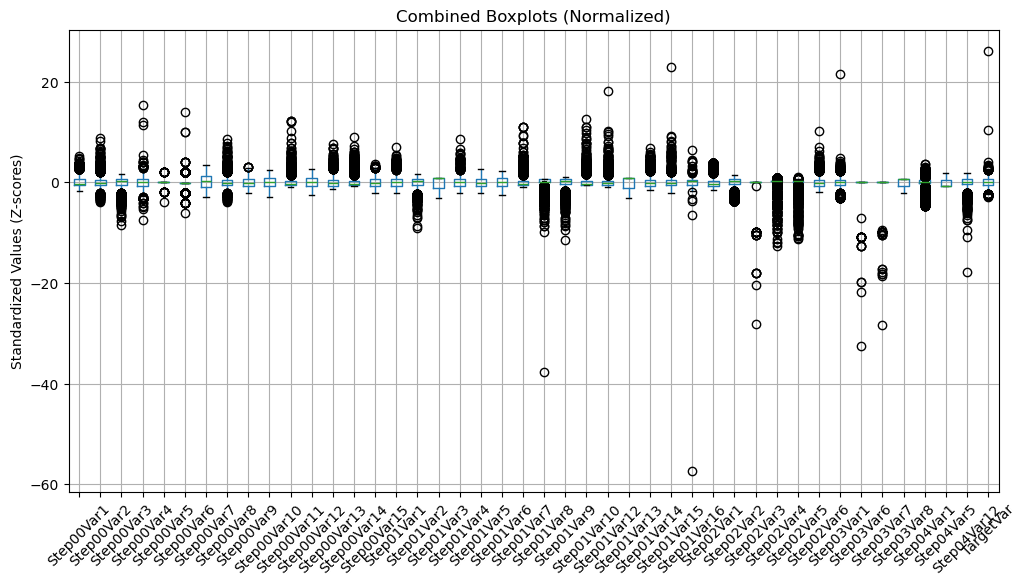

In [65]:
import pandas as pd
# Combine all variables into a single boxplot
plt.figure(figsize=(12, 6))
normalized_vars.boxplot()
plt.title('Combined Boxplots (Normalized)')
plt.xticks(rotation=45)
plt.ylabel('Standardized Values (Z-scores)')
plt.show()

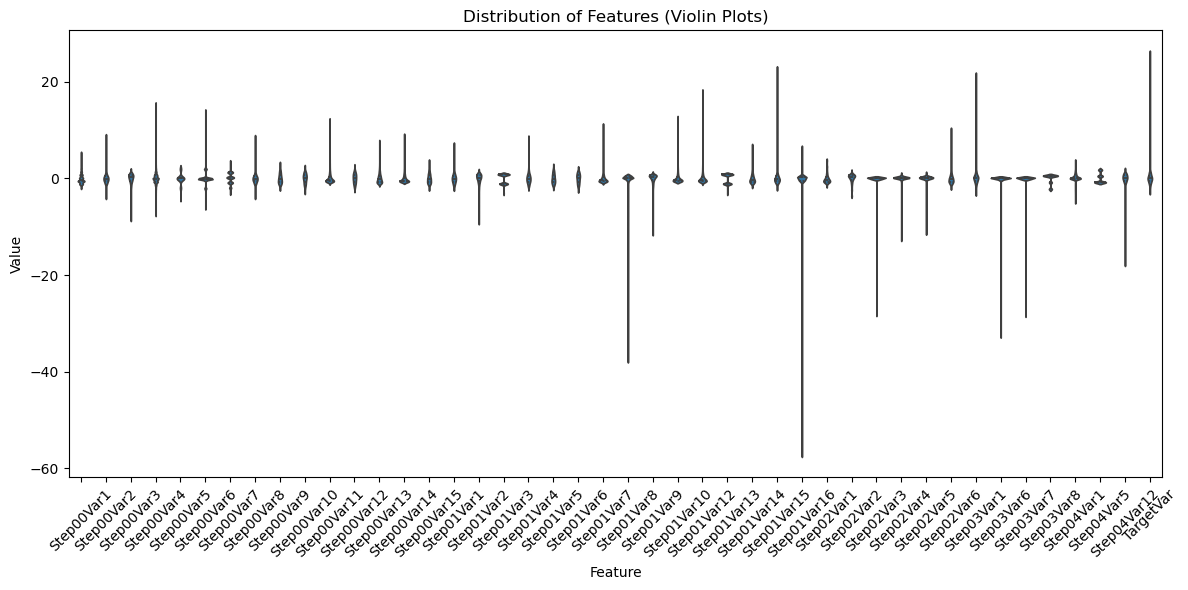

In [66]:
import seaborn as sns
# Convert data to long format for violin plot
long_df = normalized_vars.melt(var_name='Feature', value_name='Value')

plt.figure(figsize=(12, 6))
sns.violinplot(x='Feature', y='Value', data=long_df, inner='quartile')
plt.title('Distribution of Features (Violin Plots)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### The boxplots and violin plots after imputation

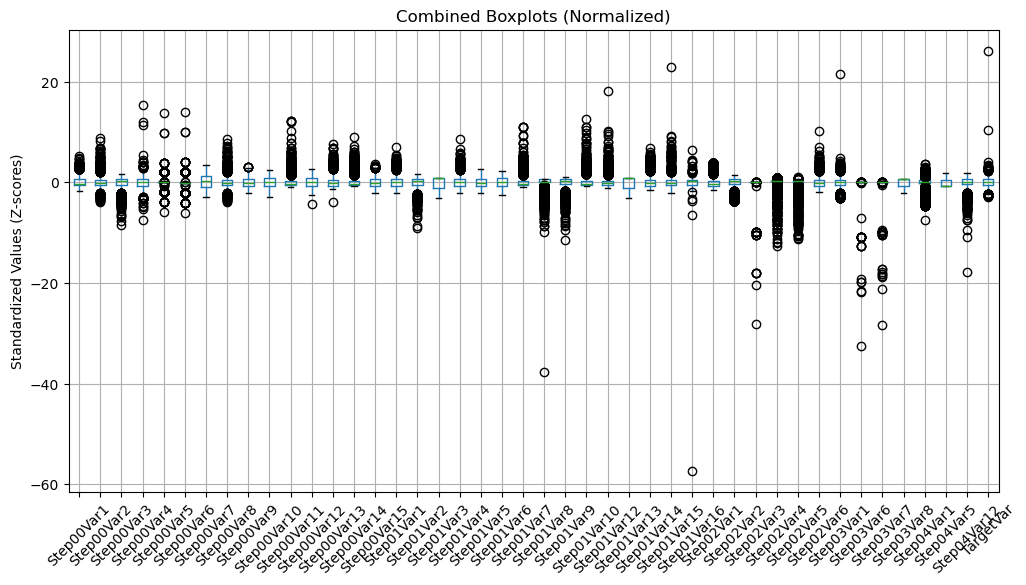

In [67]:
import pandas as pd
# Combine all variables into a single boxplot
plt.figure(figsize=(12, 6))
imputed_vars.boxplot()
plt.title('Combined Boxplots (Normalized)')
plt.xticks(rotation=45)
plt.ylabel('Standardized Values (Z-scores)')
plt.show()

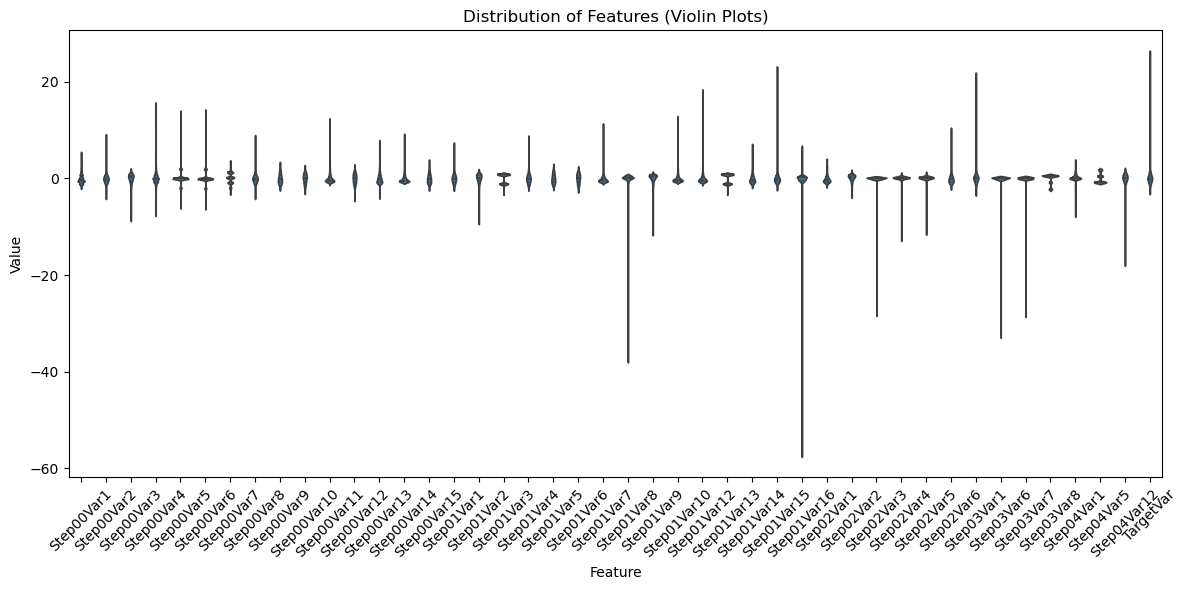

In [68]:
import seaborn as sns
# Convert data to long format for violin plot
long_df = imputed_vars.melt(var_name='Feature', value_name='Value')

plt.figure(figsize=(12, 6))
sns.violinplot(x='Feature', y='Value', data=long_df, inner='quartile')
plt.title('Distribution of Features (Violin Plots)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Outlier Detection

In [69]:
# Use Isolation Forest to deal with the outlier
from sklearn.ensemble import IsolationForest
import numpy as np
# Initialize Isolation Forest
iso_forest = IsolationForest(contamination=0.05, random_state=42)
# Fit the model and predict anomalies
imputed_vars['anomaly'] = iso_forest.fit_predict(imputed_vars)
# Anomalies are labeled as -1
anomalies = imputed_vars[imputed_vars['anomaly'] == -1]
for col in imputed_vars.columns:
    upper_limit = imputed_vars[col].quantile(0.95)
    lower_limit = imputed_vars[col].quantile(0.05)
    imputed_vars[col] = np.clip(imputed_vars[col], lower_limit, upper_limit)

## Post outlier treatment visualization

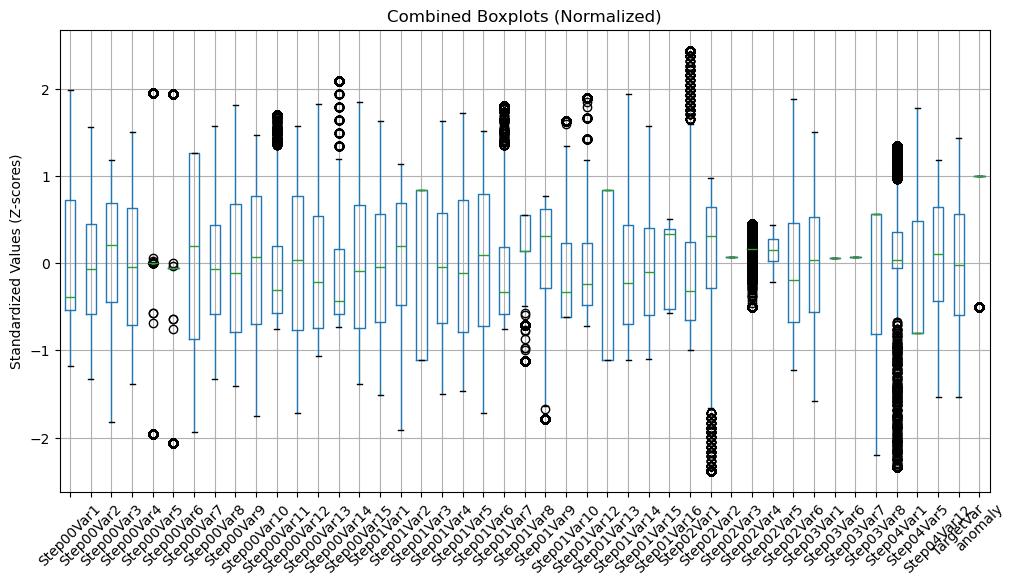

In [52]:
plt.figure(figsize=(12, 6))
imputed_vars.boxplot()
plt.title('Combined Boxplots (Normalized)')
plt.xticks(rotation=45)
plt.ylabel('Standardized Values (Z-scores)')
plt.show()

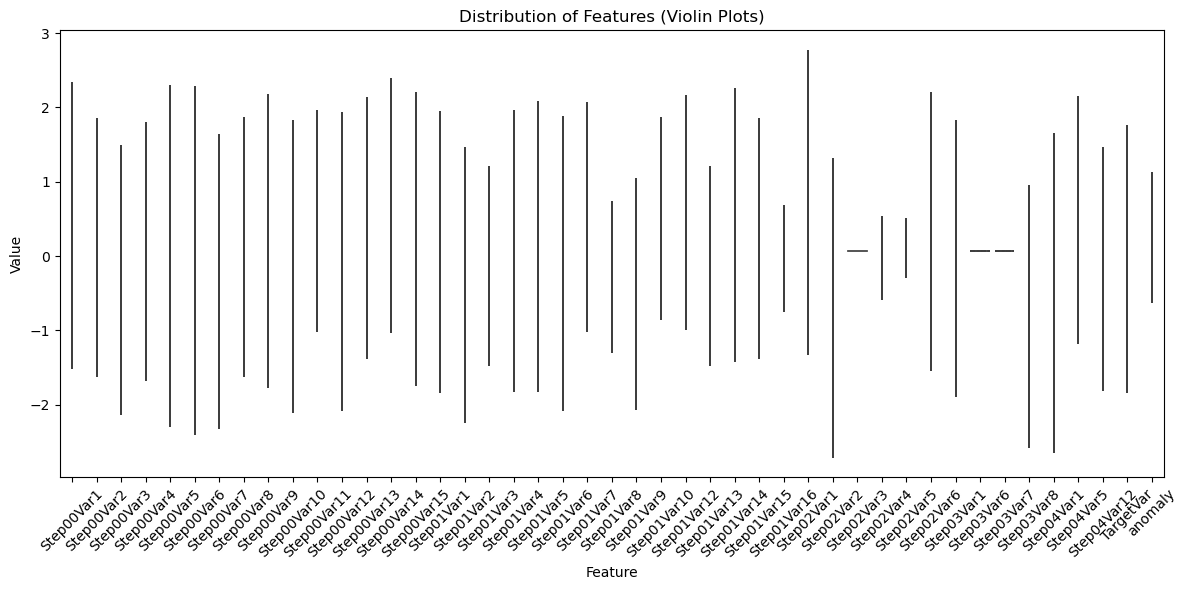

In [53]:
long_df = imputed_vars.melt(var_name='Feature', value_name='Value')
plt.figure(figsize=(12, 6))
sns.violinplot(x='Feature', y='Value', data=long_df, inner='quartile')
plt.title('Distribution of Features (Violin Plots)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()